This code is a minor modification of the molfeat example https://molfeat-docs.datamol.io/stable/tutorials/pyg_integration.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pynvml import *

In [3]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [4]:
import torch
import copy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator

from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import datamol as dm

2023-05-22 23:24:47.887523: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
torch.cuda.empty_cache()

In [6]:
print_gpu_utilization()

GPU memory occupied: 2200 MB.


In [7]:
from molfeat.utils.converters import SmilesConverter
from molfeat.trans.pretrained import PretrainedHFTransformer

In [8]:
#featurizer = PretrainedHFTransformer("Roberta-Zinc480M-102M", notation="smiles", dtype=torch.float, preload=True)
#featurizer = PretrainedHFTransformer(kind="ChemBERTa-77M-MLM", pooling="bert", preload=True)
featurizer = PretrainedHFTransformer("GPT2-Zinc480M-87M", notation="smiles", dtype=torch.float, preload=True)
#featurizer = PretrainedHFTransformer(kind="ChemGPT-1.2B", notation="selfies", device="cuda:0")
#featurizer = PretrainedHFTransformer(kind='ChemGPT-1.2B', notation='selfies', dtype=float, device="cuda:0")

In [9]:
print_gpu_utilization()

GPU memory occupied: 2200 MB.


In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/yamc/main/data/JAK2.smi",sep=" ",names=["SMILES","Name","pIC50"])

In [11]:
df

,SMILES,Name,pIC50
0,CC(C)(C)c1[nH]c2c3cc[nH]c(=O)c3c4cc(ccc4c2n1)F,CHEMBL21156,8.37000
1,CC1CCN(CC1N(C)c2c3cc[nH]c3ncn2)C(=O)CC#N,CHEMBL221959,7.62875
2,CC(COC)Nc1cc(nc(n1)n2cnc3c2cncc3)c4ccoc4,CHEMBL557844,6.85000
3,CC(c1ccc(cc1)F)Nc2cc(nc(n2)n3cnc4c3cncc4)c5ccoc5,CHEMBL221378,7.55000
4,CC(c1ccccc1)Nc2cc(nc(n2)n3cnc4c3cc(cc4)C#N)c5c...,CHEMBL375205,7.54000
...,...,...,...
2247,CNCCn1c2ccc(cc2nc1C3CCC(CC3)O)C(=O)N,CHEMBL3815154,5.41000
2248,CC(Cn1c2ccc(cc2nc1C3CCC(CC3)O)C(=O)N)O,CHEMBL3814406,4.92000
2249,c1cc2c(cc1C(=O)N)nc(n2CCCO)C3CCC(CC3)O,CHEMBL3814951,4.53000
2250,c1cc2c(cc1C(=O)N)nc(n2CCO)C3CCC(CC3)O,CHEMBL3814293,5.50000


In [12]:
class DTset(Dataset):
    def __init__(self, smiles, y, mf_featurizer):
        super().__init__()
        self.smiles = smiles
        self.mf_featurizer = mf_featurizer
        self.y = torch.tensor(y).float()
        # here we use the molfeat mf_featurizer to convert the smiles to
        # corresponding tokens based on the internal tokenizer
        # we just want the data from the batch encoding object
        self.transformed_mols = self.mf_featurizer._convert(smiles)

    @property
    def embedding_dim(self):
        return len(self.mf_featurizer)

    @property
    def max_length(self):
        return self.transformed_mols.shape[-1]
    
    def __len__(self):
        return self.y.shape[0]
    
    def collate_fn(self, **kwargs):
        # the default collate fn self.mf_featurizer.get_collate_fn(**kwargs)
        # returns None, which should just concatenate the inputs
        # You could also use `transformers.default_data_collator` instead
        return self.mf_featurizer.get_collate_fn(**kwargs)
    
    def __getitem__(self, index):
        datapoint = dict((name, val[index]) for name, val in self.transformed_mols.items())
        datapoint["y"] = self.y[index]
        return datapoint

In [13]:
train, test = train_test_split(df)
train_dt = DTset(train.SMILES.values, train.pIC50.values, featurizer)
test_dt = DTset(test.SMILES.values, test.pIC50.values, featurizer)

In [ ]:
#dataset = DTset(df.SMILES.values, df.pIC50.values, featurizer)
#generator = torch.Generator().manual_seed(42)
#train_dt, test_dt = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)

In [14]:
BATCH_SIZE = 64 
train_loader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dt.collate_fn())
test_loader = DataLoader(test_dt, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_dt.collate_fn())

In [15]:
class AwesomeNet(torch.nn.Module):
    def __init__(self, mf_featurizer, hidden_size=128, dropout=0.1, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        # we get the underlying model from the molfeat featurizer
        # here we fetch the "base" huggingface transformer model 
        # and not the wrapper around for MLM
        # this is principally to get smaller model and training efficiency
        base_pretrained_model = getattr(mf_featurizer.featurizer.model, mf_featurizer.featurizer.model.base_model_prefix)
        self.embedding_layer = copy.deepcopy(base_pretrained_model)
        self.embedding_dim = mf_featurizer.featurizer.model.config.hidden_size
        # given that we are not concatenating layers, the following is equivalent
        # self.embedding_dim = len(mf_featurizer)
        # we get the the pooling layer from the molfeat featurizer
        self.pooling_layer = mf_featurizer._pooling_obj
        self.hidden_layer = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(len(mf_featurizer), self.hidden_size),
            torch.nn.ReLU()
        )
        self.output_layer = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, *, y=None, **kwargs):
        # get embeddings
        x = self.embedding_layer(**kwargs)
        # we take the last hidden state
        # you could also set `output_hidden_states` to true above 
        # and take x["hidden_states"][-1] instead
        emb = x["last_hidden_state"]
        # run poolings
        h = self.pooling_layer(
            emb,
            kwargs["input_ids"],
            mask=kwargs.get('attention_mask'),
        )
        # run through our custom and optional hidden layer
        h = self.hidden_layer(h)
        # run through output layers to get logits
        return self.output_layer(h)

In [16]:
DEVICE = "cuda"
NUM_EPOCHS = 25
LEARNING_RATE = 1e-3
PNA_AGGREGATORS = ['mean', 'min', 'max', 'std']
PNA_SCALERS = ['identity', 'amplification', 'attenuation']

model = AwesomeNet(featurizer, hidden_size=64, dropout=0.1, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

In [17]:
print_gpu_utilization()

GPU memory occupied: 2200 MB.


In [18]:
model = model.to(DEVICE).float()
model = model.train()

In [19]:
print_gpu_utilization()

GPU memory occupied: 3119 MB.


In [21]:
loss_per_epoch_list = []
with tqdm(range(NUM_EPOCHS)) as pbar:
    for epoch in pbar:
        losses = []
        #print_gpu_utilization()
        for data in train_loader:
            for k,v in data.items():
                data[k] = data[k].to(DEVICE)
            optimizer.zero_grad()
            out = model(**data)
            loss = loss_fn(out.squeeze(), data["y"])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_per_epoch_list.append(np.mean(losses))
        pbar.set_description(f"Epoch {epoch} - Loss {np.mean(losses):.3f}")

  0%|          | 0/25 [00:00<?, ?it/s]

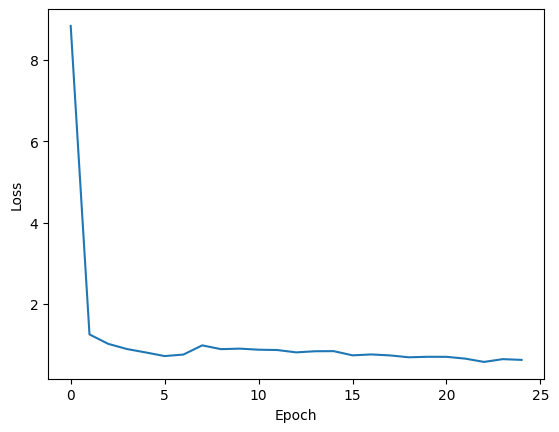

In [24]:
plot_x = list(range(0,len(loss_per_epoch_list)))
plot_y = loss_per_epoch_list
ax = sns.lineplot(x=plot_x, y=plot_y)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss");

In [23]:
model.eval()
test_y_hat = []
test_y_true = []
with torch.no_grad():
    for data in test_loader:
        for k,v in data.items():
            data[k] = data[k].to(DEVICE)
        out = model(**data)
        test_y_hat.append(out.detach().cpu().squeeze())
        test_y_true.append(data["y"])
test_y_hat = torch.cat(test_y_hat).cpu().squeeze().numpy()
test_y_true = torch.cat(test_y_true).cpu().squeeze().numpy()
rmse = mean_squared_error(test_y_true, test_y_hat, squared=False)
r2 = r2_score(test_y_true, test_y_hat)
print(f"RMSE = {rmse:.2f} R**2 = {r2:.2f}")

RMSE = 0.92 R**2 = 0.44


In [ ]:
sns.scatterplot(x=test_y_true, y=test_y_hat);